In [1]:
#패키지 불러오기
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import gensim
from random import *
import csv

https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

In [4]:
def length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
    length = tf.reduce_sum(used, 1)
    length = tf.cast(length, tf.int32)
    return length
def last_relevant(output, length):
    batch_size = tf.shape(output)[0]
    max_length = tf.shape(output)[1]
    out_size = int(output.get_shape()[2])
    index = tf.range(0, batch_size) * max_length + (length - 1)
    flat = tf.reshape(output, [-1, out_size])
    relevant = tf.gather(flat, index)
    return relevant

In [20]:
#데이터 저장
#np.save('input.npy',input_array)
#np.save('target.npy',target)

input_array=np.load('train_input_2.npy')
target=np.load('train_lab_2.npy')

val_input=np.load('val_input_2.npy')
val_lab=np.load('val_lab_2.npy')

In [4]:
input_array.shape

(90000, 8, 36)

In [5]:
target.shape

(90000, 1)

In [6]:
target

array([[1],
       [2],
       [0],
       ...,
       [0],
       [2],
       [2]])

In [26]:
# hyper parameters
input_size = input_array.shape[2]
hidden_size = 100  # RNN hidden size
output_dim = 36  # final output size (RNN or softmax, etc.)
total_batch = input_array.shape[0]
batch_size = int(input_array.shape[0]/10)  # one sample data, one batch
sequence_length = input_array.shape[1]-1  # number of lstm unfolding (unit #)
epochs= 100000
lr=0.0001
acc_batch_size=int(input_array.shape[0])
val_batch_size=int(val_input.shape[0])
num_class=4
keep_prob=1

In [8]:
batch_size

9000

In [7]:
 def get_a_cell(hidden_size, keep_prob):
            lstm = tf.contrib.rnn.LSTMCell(num_units=hidden_size,initializer=tf.contrib.layers.xavier_initializer())
            drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            return drop
        
with tf.name_scope('lstm'):
     cell = tf.nn.rnn_cell.MultiRNNCell(
     [get_a_cell(hidden_size, keep_prob) for _ in range(3)]
     )

Instructions for updating:
Use the retry module or similar alternatives.


In [8]:
#데이터를 담을 placeholder X, label을 담을 placeholder Y를 생성
X=tf.placeholder(tf.float32,[None,sequence_length+1,input_size])
Y=tf.placeholder(tf.int64,[None,1])

Y_one_hot = tf.one_hot(Y, num_class)  
Y_one_hot = tf.reshape(Y_one_hot, [-1, num_class])


#마지막 fully connected layer에서 쓸 weight과 bias 정함
weights = {
    'out': tf.Variable(tf.random_normal([hidden_size, num_class]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_class]))
}


#lstm을 돌리고 output과 state을 받음
outputs, _states = tf.nn.dynamic_rnn(cell, X, sequence_length=length(X), dtype=tf.float32)



#input데이터의 length, 몇번째 output의 값을 다음 layer로 넘겨줄지를 저장함
aa=length(X)
last = last_relevant(outputs,aa)

#마지막 output을 이용해서 prediction, sigmoid 전값을 확인할 수도 있어 일단 따로지정함
softmaxed = tf.nn.softmax(tf.matmul(last,weights['out'])+biases['out'])



#confusion_matrix
confusion_matrix=tf.confusion_matrix(tf.reshape(softmaxed,[-1]), tf.reshape(Y_one_hot,[-1]))

#prediction, accuracy
prediction = tf.argmax(softmaxed, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#이탈 유지 여부를 얼마나 맞췄나
binary_acc=tf.reduce_mean(tf.cast((tf.equal((tf.argmax(Y_one_hot, 1)>0),(prediction>0))), tf.float32))
#loss function

loss_i = tf.nn.softmax_cross_entropy_with_logits(logits=softmaxed, 

                                                 labels=Y_one_hot)

loss = tf.reduce_mean(loss_i)


#train 함수
train = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


https://github.com/tensorflow/tensorflow/issues/14897

In [7]:
sess.run(Y_one_hot,feed_dict={Y:target})

NameError: name 'sess' is not defined

In [20]:
sess.run(softmaxed,feed_dict={X:input_array})

array([[0.5085695 , 0.01712617, 0.45148635, 0.022818  ],
       [0.6452974 , 0.02595782, 0.29897824, 0.02976653],
       [0.641308  , 0.02164564, 0.30146024, 0.03558607],
       ...,
       [0.7277875 , 0.02510558, 0.22091077, 0.02619619],
       [0.5090416 , 0.01728246, 0.45077604, 0.02289989],
       [0.5381513 , 0.01823085, 0.419098  , 0.02451983]], dtype=float32)

In [3]:
#gpu가 사용 가능한지 체크
from tensorflow.python.client import device_lib

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4248296215337289677]

In [27]:
sess= tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
#epoch별 accuracy, specificity, sensitivity, precision, validation accuracy을 저장할 list를 만듦
total_acc=[]
total_sp=[]
total_se=[]
total_pr=[]
total_val_acc=[]
total_val_b_acc=[]


In [28]:

#전체 data의 confusion matrix 값을 넣을 zero matrix를 생성
cm=np.zeros(shape=(2,2),dtype=np.int32)

#gpu 사용
with tf.device("/device:GPU:0"):
    for epoch in range(epochs):
        avg_cost = 0 # 현재 epoch의 cost를 저장할 변수
        acc=0     #현재 accuracy를 저장할 변수
        sens=0    #현재 sensitivity를 저장할 변수
        spec=0    #현재 specificity를 저장할 변수
        prec=0    #현재 precision를 저장할 변수
        curr=0    #현재 batch의 range를 나타낼 변수
        curr1=0   #현재 test batch의 range를 나타낼 변수
        curr2=0   #현재 val batch의 range를 나타낼 변수
        val_acc=0 #validation accuracy를 저장할 변수
        val_binary_acc=0
        #batch normalization
        batch_iter = int(total_batch / batch_size)
        orders=np.arange(0,batch_size*batch_iter)
        #매 epoch마다 배치의 순서 자체도 shuffle
        np.random.shuffle(orders)
        
        #batch 만큼만 데이터를 넣어 학습
        for i in range(batch_iter):
            #batch 지정
            batch_xs = input_array[orders[range(curr1,curr1+batch_size)]]
            batch_ys = target[orders[range(curr1,curr1+batch_size)]]
            #어떤 data를 feed할지 지정
            feed_dict = {X: batch_xs, Y: batch_ys}
            #loss계산, 학습
            c, _ = sess.run([loss, train], feed_dict=feed_dict)
            
            #다음 batch
            curr1 += batch_size
            
            #cost 저장
            avg_cost += c / batch_iter
        #test batch만큼씩 넣어 각 값을 구함
        for j in range(1):
            batch2_xs = input_array[range(curr,curr+acc_batch_size)]
            batch2_ys = target[range(curr,curr+acc_batch_size)]
            b_acc = sess.run([accuracy], feed_dict={X:batch2_xs,Y: batch2_ys})
            #다음 batch
            curr += acc_batch_size
            
            #현재 accuracy를 저장
            acc += b_acc[0]
        for k in range(1):
            batch2_xs = val_input[range(curr2,curr2+val_batch_size)]
            batch2_ys = val_lab[range(curr2,curr2+val_batch_size)]
            v_acc,v_b_acc = sess.run([accuracy,binary_acc], feed_dict={X:batch2_xs,Y: batch2_ys})
            #다음 batch
            curr2 += val_batch_size
            #현재 accuracy를 저장
            val_acc += v_acc
            val_binary_acc+=v_b_acc
        
        total_acc.append(acc)
        total_val_acc.append(val_acc)
        total_val_b_acc.append(val_binary_acc)
            
        #매 epoch마다 지표 출력
        print("epoch : ", epoch,"  cost : ", avg_cost, "  accuracy : ", acc,"val_acc: ", val_acc,"val_binary_acc", val_binary_acc
              )
        


epoch :  0   cost :  1.311037003993988   accuracy :  0.43220001459121704 val_acc:  0.42669999599456787 val_binary_acc 0.7882999777793884
epoch :  1   cost :  1.26708265542984   accuracy :  0.5188999772071838 val_acc:  0.517799973487854 val_binary_acc 0.8076000213623047
epoch :  2   cost :  1.2352174043655393   accuracy :  0.538777768611908 val_acc:  0.5397999882698059 val_binary_acc 0.8052999973297119
epoch :  3   cost :  1.197083306312561   accuracy :  0.5040555596351624 val_acc:  0.5015000104904175 val_binary_acc 0.8346999883651733
epoch :  4   cost :  1.1686894059181212   accuracy :  0.5692444443702698 val_acc:  0.5705000162124634 val_binary_acc 0.8345000147819519
epoch :  5   cost :  1.1616035223007202   accuracy :  0.567455530166626 val_acc:  0.5724999904632568 val_binary_acc 0.8355000019073486
epoch :  6   cost :  1.1490442276000976   accuracy :  0.5904555320739746 val_acc:  0.5928000211715698 val_binary_acc 0.8452000021934509
epoch :  7   cost :  1.1389972686767578   accuracy : 

epoch :  70   cost :  1.0890072822570802   accuracy :  0.6462888717651367 val_acc:  0.6499999761581421 val_binary_acc 0.8659999966621399
epoch :  71   cost :  1.0857437133789065   accuracy :  0.6373222470283508 val_acc:  0.6317999958992004 val_binary_acc 0.864799976348877
epoch :  72   cost :  1.0846165776252747   accuracy :  0.649399995803833 val_acc:  0.6517999768257141 val_binary_acc 0.8687999844551086
epoch :  73   cost :  1.0852741956710814   accuracy :  0.6504555344581604 val_acc:  0.6538000106811523 val_binary_acc 0.8689000010490417
epoch :  74   cost :  1.084567654132843   accuracy :  0.6512110829353333 val_acc:  0.6549999713897705 val_binary_acc 0.8689000010490417
epoch :  75   cost :  1.083283770084381   accuracy :  0.6521000266075134 val_acc:  0.6552000045776367 val_binary_acc 0.8676000237464905
epoch :  76   cost :  1.083870780467987   accuracy :  0.6517333388328552 val_acc:  0.6550999879837036 val_binary_acc 0.8687000274658203
epoch :  77   cost :  1.0830581784248352   acc

epoch :  130   cost :  1.067293667793274   accuracy :  0.6732110977172852 val_acc:  0.6764000058174133 val_binary_acc 0.8708999752998352
epoch :  131   cost :  1.0630350351333617   accuracy :  0.6729555726051331 val_acc:  0.6730999946594238 val_binary_acc 0.8737000226974487
epoch :  132   cost :  1.062207567691803   accuracy :  0.6743999719619751 val_acc:  0.6764000058174133 val_binary_acc 0.8744999766349792
epoch :  133   cost :  1.0616251230239868   accuracy :  0.6759333610534668 val_acc:  0.6783999800682068 val_binary_acc 0.8726000189781189
epoch :  134   cost :  1.061076319217682   accuracy :  0.6770333051681519 val_acc:  0.6775000095367432 val_binary_acc 0.8712999820709229
epoch :  135   cost :  1.0599162697792055   accuracy :  0.6759111285209656 val_acc:  0.6776999831199646 val_binary_acc 0.8725000023841858
epoch :  136   cost :  1.0603105425834656   accuracy :  0.6772778034210205 val_acc:  0.6794999837875366 val_binary_acc 0.8774999976158142
epoch :  137   cost :  1.059997165203

epoch :  190   cost :  1.0505666971206664   accuracy :  0.6876888871192932 val_acc:  0.6865000128746033 val_binary_acc 0.8762999773025513
epoch :  191   cost :  1.0524449467658996   accuracy :  0.686477780342102 val_acc:  0.6840000152587891 val_binary_acc 0.878000020980835
epoch :  192   cost :  1.0509405255317688   accuracy :  0.686033308506012 val_acc:  0.6840999722480774 val_binary_acc 0.8766000270843506
epoch :  193   cost :  1.0499978065490723   accuracy :  0.6875110864639282 val_acc:  0.6870999932289124 val_binary_acc 0.8769999742507935
epoch :  194   cost :  1.0495447397232056   accuracy :  0.6883666515350342 val_acc:  0.6866000294685364 val_binary_acc 0.8791999816894531
epoch :  195   cost :  1.0489152908325194   accuracy :  0.6886110901832581 val_acc:  0.6876000165939331 val_binary_acc 0.878600001335144
epoch :  196   cost :  1.0494447588920595   accuracy :  0.6887555718421936 val_acc:  0.6862000226974487 val_binary_acc 0.8773999810218811
epoch :  197   cost :  1.0491017937660

epoch :  250   cost :  1.0408227682113647   accuracy :  0.6956111192703247 val_acc:  0.6897000074386597 val_binary_acc 0.8830999732017517
epoch :  251   cost :  1.041031527519226   accuracy :  0.6969444155693054 val_acc:  0.6905999779701233 val_binary_acc 0.8788999915122986
epoch :  252   cost :  1.0402034521102905   accuracy :  0.6988000273704529 val_acc:  0.6917999982833862 val_binary_acc 0.879800021648407
epoch :  253   cost :  1.039335584640503   accuracy :  0.6987555623054504 val_acc:  0.6929000020027161 val_binary_acc 0.8819000124931335
epoch :  254   cost :  1.040118610858917   accuracy :  0.6975666880607605 val_acc:  0.6904000043869019 val_binary_acc 0.879800021648407
epoch :  255   cost :  1.0396098613739015   accuracy :  0.697422206401825 val_acc:  0.6904000043869019 val_binary_acc 0.8806999921798706
epoch :  256   cost :  1.0401479840278625   accuracy :  0.6980555653572083 val_acc:  0.6916000247001648 val_binary_acc 0.8792999982833862
epoch :  257   cost :  1.040045750141143

epoch :  310   cost :  1.0335132479667664   accuracy :  0.7026777863502502 val_acc:  0.6916999816894531 val_binary_acc 0.8799999952316284
epoch :  311   cost :  1.0332170367240905   accuracy :  0.7040333151817322 val_acc:  0.6956999897956848 val_binary_acc 0.8763999938964844
epoch :  312   cost :  1.0323803424835205   accuracy :  0.7048888802528381 val_acc:  0.6952000260353088 val_binary_acc 0.8813999891281128
epoch :  313   cost :  1.0321272373199464   accuracy :  0.70615553855896 val_acc:  0.6966000199317932 val_binary_acc 0.8780999779701233
epoch :  314   cost :  1.0316147685050965   accuracy :  0.7061777710914612 val_acc:  0.6931999921798706 val_binary_acc 0.8823999762535095
epoch :  315   cost :  1.031575608253479   accuracy :  0.7047222256660461 val_acc:  0.6949999928474426 val_binary_acc 0.8806999921798706
epoch :  316   cost :  1.0319530010223388   accuracy :  0.7061777710914612 val_acc:  0.694599986076355 val_binary_acc 0.8823999762535095
epoch :  317   cost :  1.0309269785881

epoch :  370   cost :  1.0263259887695315   accuracy :  0.7121888995170593 val_acc:  0.6978999972343445 val_binary_acc 0.8804000020027161
epoch :  371   cost :  1.0265491962432862   accuracy :  0.7079889178276062 val_acc:  0.694599986076355 val_binary_acc 0.8816999793052673
epoch :  372   cost :  1.029103684425354   accuracy :  0.7072666883468628 val_acc:  0.6953999996185303 val_binary_acc 0.8823000192642212
epoch :  373   cost :  1.0302400469779969   accuracy :  0.7070000171661377 val_acc:  0.6930000185966492 val_binary_acc 0.8827999830245972
epoch :  374   cost :  1.0291722178459168   accuracy :  0.7099888920783997 val_acc:  0.6960999965667725 val_binary_acc 0.8790000081062317
epoch :  375   cost :  1.0276942491531373   accuracy :  0.7099666595458984 val_acc:  0.6955999732017517 val_binary_acc 0.882099986076355
epoch :  376   cost :  1.026744890213013   accuracy :  0.711222231388092 val_acc:  0.6970999836921692 val_binary_acc 0.880299985408783
epoch :  377   cost :  1.026334142684936

epoch :  430   cost :  1.0213598251342775   accuracy :  0.7166222333908081 val_acc:  0.6983000040054321 val_binary_acc 0.8817999958992004
epoch :  431   cost :  1.0220470666885375   accuracy :  0.715399980545044 val_acc:  0.695900022983551 val_binary_acc 0.8787999749183655
epoch :  432   cost :  1.0214779257774353   accuracy :  0.7162777781486511 val_acc:  0.6966999769210815 val_binary_acc 0.8808000087738037
epoch :  433   cost :  1.021674704551697   accuracy :  0.7163222432136536 val_acc:  0.697700023651123 val_binary_acc 0.8816999793052673
epoch :  434   cost :  1.0219227790832521   accuracy :  0.7157999873161316 val_acc:  0.6980000138282776 val_binary_acc 0.8822000026702881
epoch :  435   cost :  1.0214380860328673   accuracy :  0.7165111303329468 val_acc:  0.6976000070571899 val_binary_acc 0.8809000253677368
epoch :  436   cost :  1.0217354059219361   accuracy :  0.7146888971328735 val_acc:  0.6967999935150146 val_binary_acc 0.8794000148773193
epoch :  437   cost :  1.0223220467567

epoch :  490   cost :  1.018744742870331   accuracy :  0.719355583190918 val_acc:  0.6983000040054321 val_binary_acc 0.8835999965667725
epoch :  491   cost :  1.0185450315475466   accuracy :  0.7194888591766357 val_acc:  0.698199987411499 val_binary_acc 0.8809999823570251
epoch :  492   cost :  1.0185403943061828   accuracy :  0.7187222242355347 val_acc:  0.6980000138282776 val_binary_acc 0.8788999915122986
epoch :  493   cost :  1.0173370122909546   accuracy :  0.7195555567741394 val_acc:  0.6984000205993652 val_binary_acc 0.8848000168800354
epoch :  494   cost :  1.017341887950897   accuracy :  0.7202444672584534 val_acc:  0.6980000138282776 val_binary_acc 0.8809999823570251
epoch :  495   cost :  1.0170724511146545   accuracy :  0.7204111218452454 val_acc:  0.6995000243186951 val_binary_acc 0.8830999732017517
epoch :  496   cost :  1.0176892161369322   accuracy :  0.7198777794837952 val_acc:  0.6992999911308289 val_binary_acc 0.8808000087738037
epoch :  497   cost :  1.0171895980834

epoch :  550   cost :  1.0141220569610594   accuracy :  0.7238222360610962 val_acc:  0.7003999948501587 val_binary_acc 0.8840000033378601
epoch :  551   cost :  1.0135740518569947   accuracy :  0.7243000268936157 val_acc:  0.6995999813079834 val_binary_acc 0.8831999897956848
epoch :  552   cost :  1.0132455587387086   accuracy :  0.7245000004768372 val_acc:  0.6992999911308289 val_binary_acc 0.8823000192642212
epoch :  553   cost :  1.0134438514709474   accuracy :  0.7237333059310913 val_acc:  0.7002000212669373 val_binary_acc 0.8841999769210815
epoch :  554   cost :  1.013838541507721   accuracy :  0.7224555611610413 val_acc:  0.7005000114440918 val_binary_acc 0.8847000002861023
epoch :  555   cost :  1.014474618434906   accuracy :  0.7239999771118164 val_acc:  0.699999988079071 val_binary_acc 0.885200023651123
epoch :  556   cost :  1.0135159134864806   accuracy :  0.7241111397743225 val_acc:  0.7002000212669373 val_binary_acc 0.8835999965667725
epoch :  557   cost :  1.0134424090385

epoch :  610   cost :  1.0073816180229187   accuracy :  0.7299333214759827 val_acc:  0.70660001039505 val_binary_acc 0.887499988079071
epoch :  611   cost :  1.0078292131423952   accuracy :  0.7298444509506226 val_acc:  0.7056000232696533 val_binary_acc 0.8888999819755554
epoch :  612   cost :  1.0082310557365417   accuracy :  0.7273666858673096 val_acc:  0.7034000158309937 val_binary_acc 0.886900007724762
epoch :  613   cost :  1.0084540486335754   accuracy :  0.7305999994277954 val_acc:  0.7050999999046326 val_binary_acc 0.8871999979019165
epoch :  614   cost :  1.0074660003185272   accuracy :  0.7305222153663635 val_acc:  0.7045000195503235 val_binary_acc 0.8876000046730042
epoch :  615   cost :  1.0066230058670045   accuracy :  0.731855571269989 val_acc:  0.7045000195503235 val_binary_acc 0.8865000009536743
epoch :  616   cost :  1.007148015499115   accuracy :  0.7308222055435181 val_acc:  0.7052000164985657 val_binary_acc 0.8873999714851379
epoch :  617   cost :  1.006383490562439

epoch :  670   cost :  1.0050813376903533   accuracy :  0.7319889068603516 val_acc:  0.7044000029563904 val_binary_acc 0.8873999714851379
epoch :  671   cost :  1.0056499600410462   accuracy :  0.7330555319786072 val_acc:  0.7055000066757202 val_binary_acc 0.8867999911308289
epoch :  672   cost :  1.0049394965171814   accuracy :  0.7329555749893188 val_acc:  0.704800009727478 val_binary_acc 0.8866999745368958
epoch :  673   cost :  1.0044254660606386   accuracy :  0.7344222068786621 val_acc:  0.7077999711036682 val_binary_acc 0.8885999917984009
epoch :  674   cost :  1.003769117593765   accuracy :  0.7342888712882996 val_acc:  0.7067999839782715 val_binary_acc 0.8881000280380249
epoch :  675   cost :  1.0035823464393616   accuracy :  0.7338444590568542 val_acc:  0.7050999999046326 val_binary_acc 0.886900007724762
epoch :  676   cost :  1.0042307317256927   accuracy :  0.732877790927887 val_acc:  0.7063000202178955 val_binary_acc 0.8853999972343445
epoch :  677   cost :  1.0043093264102

epoch :  730   cost :  1.0029101550579074   accuracy :  0.7347555756568909 val_acc:  0.7055000066757202 val_binary_acc 0.8876000046730042
epoch :  731   cost :  1.0030144155025484   accuracy :  0.7354888916015625 val_acc:  0.7056000232696533 val_binary_acc 0.8880000114440918
epoch :  732   cost :  1.002393639087677   accuracy :  0.7351111173629761 val_acc:  0.7057999968528748 val_binary_acc 0.887499988079071
epoch :  733   cost :  1.0021904706954954   accuracy :  0.7357110977172852 val_acc:  0.7059999704360962 val_binary_acc 0.8878999948501587
epoch :  734   cost :  1.0021107614040374   accuracy :  0.736311137676239 val_acc:  0.7059000134468079 val_binary_acc 0.8878999948501587
epoch :  735   cost :  1.0013483464717865   accuracy :  0.7372000217437744 val_acc:  0.7081999778747559 val_binary_acc 0.8892999887466431
epoch :  736   cost :  1.0009911715984345   accuracy :  0.7373889088630676 val_acc:  0.7081999778747559 val_binary_acc 0.8876000046730042
epoch :  737   cost :  1.001066941022

epoch :  790   cost :  0.9996373891830443   accuracy :  0.7387111186981201 val_acc:  0.7074999809265137 val_binary_acc 0.8881999850273132
epoch :  791   cost :  0.9994790077209473   accuracy :  0.7383221983909607 val_acc:  0.7077000141143799 val_binary_acc 0.8884000182151794
epoch :  792   cost :  0.999226176738739   accuracy :  0.7383111119270325 val_acc:  0.7077000141143799 val_binary_acc 0.8881999850273132
epoch :  793   cost :  0.9990851938724519   accuracy :  0.7390000224113464 val_acc:  0.7074000239372253 val_binary_acc 0.888700008392334
epoch :  794   cost :  0.9990721166133879   accuracy :  0.7393110990524292 val_acc:  0.7080000042915344 val_binary_acc 0.8881000280380249
epoch :  795   cost :  0.9985874593257904   accuracy :  0.739799976348877 val_acc:  0.7110999822616577 val_binary_acc 0.8903999924659729
epoch :  796   cost :  0.9983967602252959   accuracy :  0.7396000027656555 val_acc:  0.7067999839782715 val_binary_acc 0.8877999782562256
epoch :  797   cost :  0.998243165016

epoch :  850   cost :  0.9968958854675293   accuracy :  0.740933358669281 val_acc:  0.7070000171661377 val_binary_acc 0.8883000016212463
epoch :  851   cost :  0.9971751809120178   accuracy :  0.7408221960067749 val_acc:  0.7070000171661377 val_binary_acc 0.8873000144958496
epoch :  852   cost :  0.9968115508556366   accuracy :  0.7404555678367615 val_acc:  0.7064999938011169 val_binary_acc 0.8870999813079834
epoch :  853   cost :  0.9968624889850617   accuracy :  0.7404999732971191 val_acc:  0.7077999711036682 val_binary_acc 0.8894000053405762
epoch :  854   cost :  0.9971318900585175   accuracy :  0.7412222027778625 val_acc:  0.7056999802589417 val_binary_acc 0.8860999941825867
epoch :  855   cost :  0.9969700336456299   accuracy :  0.7408444285392761 val_acc:  0.7067999839782715 val_binary_acc 0.8895999789237976
epoch :  856   cost :  0.9973878920078278   accuracy :  0.7403888702392578 val_acc:  0.70660001039505 val_binary_acc 0.8881999850273132
epoch :  857   cost :  0.997514373064

KeyboardInterrupt: 

In [15]:
sess.run(accuracy,feed_dict={X:val_input,Y:val_lab})

0.6717

In [16]:
sess.run(tf.reduce_mean(tf.cast((tf.equal((tf.argmax(Y_one_hot, 1)>0),(prediction>0))), tf.float32)),feed_dict={X:val_input,Y:val_lab})

0.8777

In [21]:
sess.run(Y_one_hot,feed_dict={Y:val_lab})

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [22]:
val_lab

array([[2],
       [0],
       [3],
       ...,
       [1],
       [3],
       [0]])

In [17]:
sess.run( (prediction>0),feed_dict={X:val_input,Y:val_lab})

array([ True,  True,  True, ...,  True,  True, False])

In [8]:
#epoch별 accuracy, specificity, sensitivity, precision, validation accuracy을 저장할 list를 만듦
total_acc=[]
total_sp=[]
total_se=[]
total_pr=[]
total_val_acc=[]

#전체 data의 confusion matrix 값을 넣을 zero matrix를 생성
cm=np.zeros(shape=(2,2),dtype=np.int32)

#gpu 사용
with tf.device("/device:GPU:0"):
    for epoch in range(epoch):
        avg_cost = 0 # 현재 epoch의 cost를 저장할 변수
        acc=0     #현재 accuracy를 저장할 변수
        sens=0    #현재 sensitivity를 저장할 변수
        spec=0    #현재 specificity를 저장할 변수
        prec=0    #현재 precision를 저장할 변수
        curr=0    #현재 batch의 range를 나타낼 변수
        curr1=0   #현재 test batch의 range를 나타낼 변수
        curr2=0   #현재 val batch의 range를 나타낼 변수
        val_acc=0 #validation accuracy를 저장할 변수
        #batch normalization
        batch_iter = int(total_batch / batch_size)
        orders=np.arange(0,batch_size*batch_iter)
        #매 epoch마다 배치의 순서 자체도 shuffle
        np.random.shuffle(orders)
        
        #batch 만큼만 데이터를 넣어 학습
        for i in range(batch_iter):
            #batch 지정
            batch_xs = input_array[orders[range(curr,curr+batch_size)]]
            batch_ys = target[orders[range(curr,curr+batch_size)]]
            #어떤 data를 feed할지 지정
            feed_dict = {X: batch_xs, Y: batch_ys}
            #loss계산, 학습
            c, _ = sess.run([loss, train], feed_dict=feed_dict)
            
            #다음 batch
            curr1 += batch_size
            
            #cost 저장
            avg_cost += c / batch_iter
        #test batch만큼씩 넣어 각 값을 구함
        for j in range(1):
            batch2_xs = input_array[range(curr,curr+acc_batch_size)]
            batch2_ys = target[range(curr,curr+acc_batch_size)]
            b_acc,cf = sess.run([accuracy,confusion_matrix], feed_dict={X:batch2_xs,Y: batch2_ys})
            #다음 batch
            curr += acc_batch_size
            
            #현재 accuracy를 저장
            acc += b_acc/10    
            #현재 batch에서의 confusionmatrix의 값을 저장
            cm += cf
        
        #val batch만큼씩 넣어 각 값을 구함
        for j in range(3):
            batch3_xs = val_d[range(curr2,curr2+val_batch_size)]
            batch3_ys = val_l[range(curr2,curr2+val_batch_size)]
            v_acc = sess.run([accuracy], feed_dict={X:batch3_xs,Y: batch3_ys})
            #다음 batch
            curr2 += val_batch_size
            
            #현재 accuracy를 저장
            val_acc += v_acc[0]/3
        
        #label값이 0,1이므로 보통 confusion matrix의 값과는 다른 형태가 나옴, 각 지표을 계산
        sens +=cm[1,1]/(cm[1,1]+cm[0,1])
        spec +=cm[0,0]/(cm[0,0]+cm[1,0])
        prec +=cm[1,1]/(cm[1,1]+cm[1,0])
        
        #현재 epoch의 지표를 저장
        total_acc.append(acc)
        total_sp.append(spec)
        total_se.append(sens)
        total_pr.append(prec)
        total_val_acc.append(val_acc)
        #매 epoch마다 지표 출력
        print("epoch : ", epoch,"  cost : ", avg_cost, "  accuracy : ", acc,
              "\nspecificity : ",spec, "  sensitivity : ", sens, "  precision : ", prec,
              "\nvalidation accuracy : ")
        if (epoch+1) % 100 == 0:
            saver.save(sess, "my_test_model/2lstm_1fc_real_data", global_step=epoch+1)


InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [3600000] != values[1].shape = [400000]
	 [[Node: confusion_matrix/stack_1 = Pack[N=2, T=DT_INT64, axis=1, _device="/job:localhost/replica:0/task:0/device:GPU:0"](confusion_matrix/control_dependency, confusion_matrix/control_dependency_1)]]
	 [[Node: confusion_matrix/stack/_127 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_303_confusion_matrix/stack", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'confusion_matrix/stack_1', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-8d7d771ffe42>", line 33, in <module>
    confusion_matrix=tf.confusion_matrix(tf.reshape(softmaxed,[-1]), tf.reshape(Y_one_hot,[-1]))
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/confusion_matrix.py", line 189, in confusion_matrix
    indices = array_ops.stack([labels, predictions], axis=1)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 945, in stack
    return gen_array_ops.pack(values, axis=axis, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4191, in pack
    "Pack", values=values, axis=axis, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Shapes of all inputs must match: values[0].shape = [3600000] != values[1].shape = [400000]
	 [[Node: confusion_matrix/stack_1 = Pack[N=2, T=DT_INT64, axis=1, _device="/job:localhost/replica:0/task:0/device:GPU:0"](confusion_matrix/control_dependency, confusion_matrix/control_dependency_1)]]
	 [[Node: confusion_matrix/stack/_127 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_303_confusion_matrix/stack", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


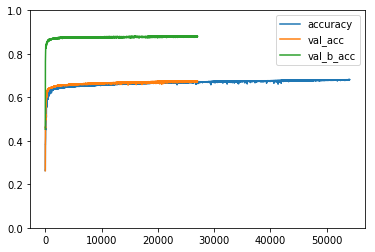

In [23]:
#ggplot처럼 plot  하나씩 추가하는 겁니다.
plt.plot(total_acc,label = 'accuracy')
plt.plot(total_val_acc,label = 'val_acc')
plt.plot(total_val_b_acc,label = 'val_b_acc')
plt.legend()
#이렇게 두개하면 두개가 그려짐

#데이터를 하나만 넣으면 index(x축에따라) 데이터가 어떻게 달라지는지를 출력해주어서
#y의 범위를 지정해줘야 됩니다.
#범위 지정안하면 min max가 lim 이됨
plt.ylim(0,1)

#플랏을 띄워주라는 명령어
plt.show()

In [18]:
len(total_val_acc)

26884

In [10]:
outputs

<tf.Tensor 'rnn/transpose_1:0' shape=(?, 88, 300) dtype=float32>

In [11]:
np.stack

<function numpy.core.shape_base.stack(arrays, axis=0, out=None)>

In [15]:
aa= input_array[0:3]
aa.shape

(3, 88, 300)

In [25]:
aaa=np.stack((aa[0,1,:],aa[0,2,:]),axis=0)
np.stack((aaa[0],aa[0,1,:],aa[0,2,:]),axis=0).shape

(3, 300)

In [30]:
def shaping(inputs,l_word,batch_size):
    for k in range(batch_size):
        if k is 0:
            new_arr = (inputs[k,l_word])
        else :
            new_arr = new_arr+(inputs[k,l_word])
    return np.stack(new_arr)
            
            